# Demonstrate accessing UM N2560 5km RAL3 data from zarr on JASMIN object store

* First look at simulations for WCRP Hackathon UK Node.
* Can be run on JASMIN or anywhere else: set `on_jasmin`.
* Can fetch healpix zoom levels 10-0. Levels 8+ might be slow to load outside JASMIN.
* Tested using this Python conda env: https://github.com/digital-earths-global-hackathon/tools/blob/main/python_envs/environment.yaml (with some extra packages).
* Data is still experimental - problem with processing means it uses float64 instead of float32. Haven't properly tested time alignment yet.
* I believe there is a plotting issue at lon=0 - and that data is OK.
* Contact mark.muetzelfeldt@reading.ac.uk for more info.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh

/home/users/mmuetz/miniforge3/envs/hackathon_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
on_jasmin = True
url_tpls = {}
if on_jasmin:
    url_tpls['2d'] = 'http://hackathon-o.s3.jc.rl.ac.uk/sim-data/DYAMOND3_example_data/5km-RAL3/2d/data.2d.z{zoom}.zarr'
    url_tpls['3d'] = 'http://hackathon-o.s3.jc.rl.ac.uk/sim-data/DYAMOND3_example_data/5km-RAL3/3d/data.full.v3.3d.z{zoom}.zarr'
else:
    url_tpls['2d'] = 'https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/DYAMOND3_example_data/5km-RAL3/2d/data.2d.z{zoom}.zarr'
    url_tpls['3d'] = 'https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/DYAMOND3_example_data/5km-RAL3/3d/data.full.v3.3d.z{zoom}.zarr'

In [3]:
ds2d = xr.open_zarr(url_tpls['2d'].format(zoom=10))
ds2d

<xarray.Dataset> Size: 24TB
Dimensions:        (cell: 12582912, time: 9745, time_halfpast: 9744)
Coordinates:
  * cell           (cell) int64 101MB 0 1 2 3 ... 12582909 12582910 12582911
  * time           (time) datetime64[ns] 78kB 2020-01-20 ... 2021-03-01
  * time_halfpast  (time_halfpast) datetime64[ns] 78kB 2020-01-20T00:30:00 .....
Data variables: (12/24)
    clivi          (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt            (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi          (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd          (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd          (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss           (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...             ...
    rsut           (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    rsutcs         (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    tas            (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts             (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas            (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas            (time, cell) float64 981GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

In [4]:
def plot_all_fields_2d(zoom, time_idx):
    ds_plot = xr.open_zarr(url_tpls['2d'].format(zoom=zoom))

    projection = ccrs.Robinson(central_longitude=0)
    
    fig, axes = plt.subplots(6, 4, figsize=(30, 20), subplot_kw={'projection': projection}, layout='constrained')
    plt.suptitle(f'UM N2560 RAL3 healpix zoom={zoom}')
    
    for ax, (name, da) in zip(axes.flatten(), ds_plot.data_vars.items()):
        print(name)
        timename = [c for c in da.coords if c.startswith('time')][0]
        time = pd.Timestamp(ds_plot[timename].values[time_idx])
    
        data = da.isel(**{timename: time_idx})
        ax.set_title(f'{timename}: {time} - {name}')
        ax.set_global()
        im = egh.healpix_show(data.values, ax=ax);
        long_name = da.long_name
            
        plt.colorbar(im, label=f'{long_name} ({da.attrs.get("units", "-")})')
        ax.coastlines()

clivi
clt
clwvi
hflsd
hfssd
huss
pr
prs
prw
ps
psl
rldscs
rldt
rlut
rlutcs
rsds
rsdscs
rsdt
rsut
rsutcs
tas
ts
uas
vas


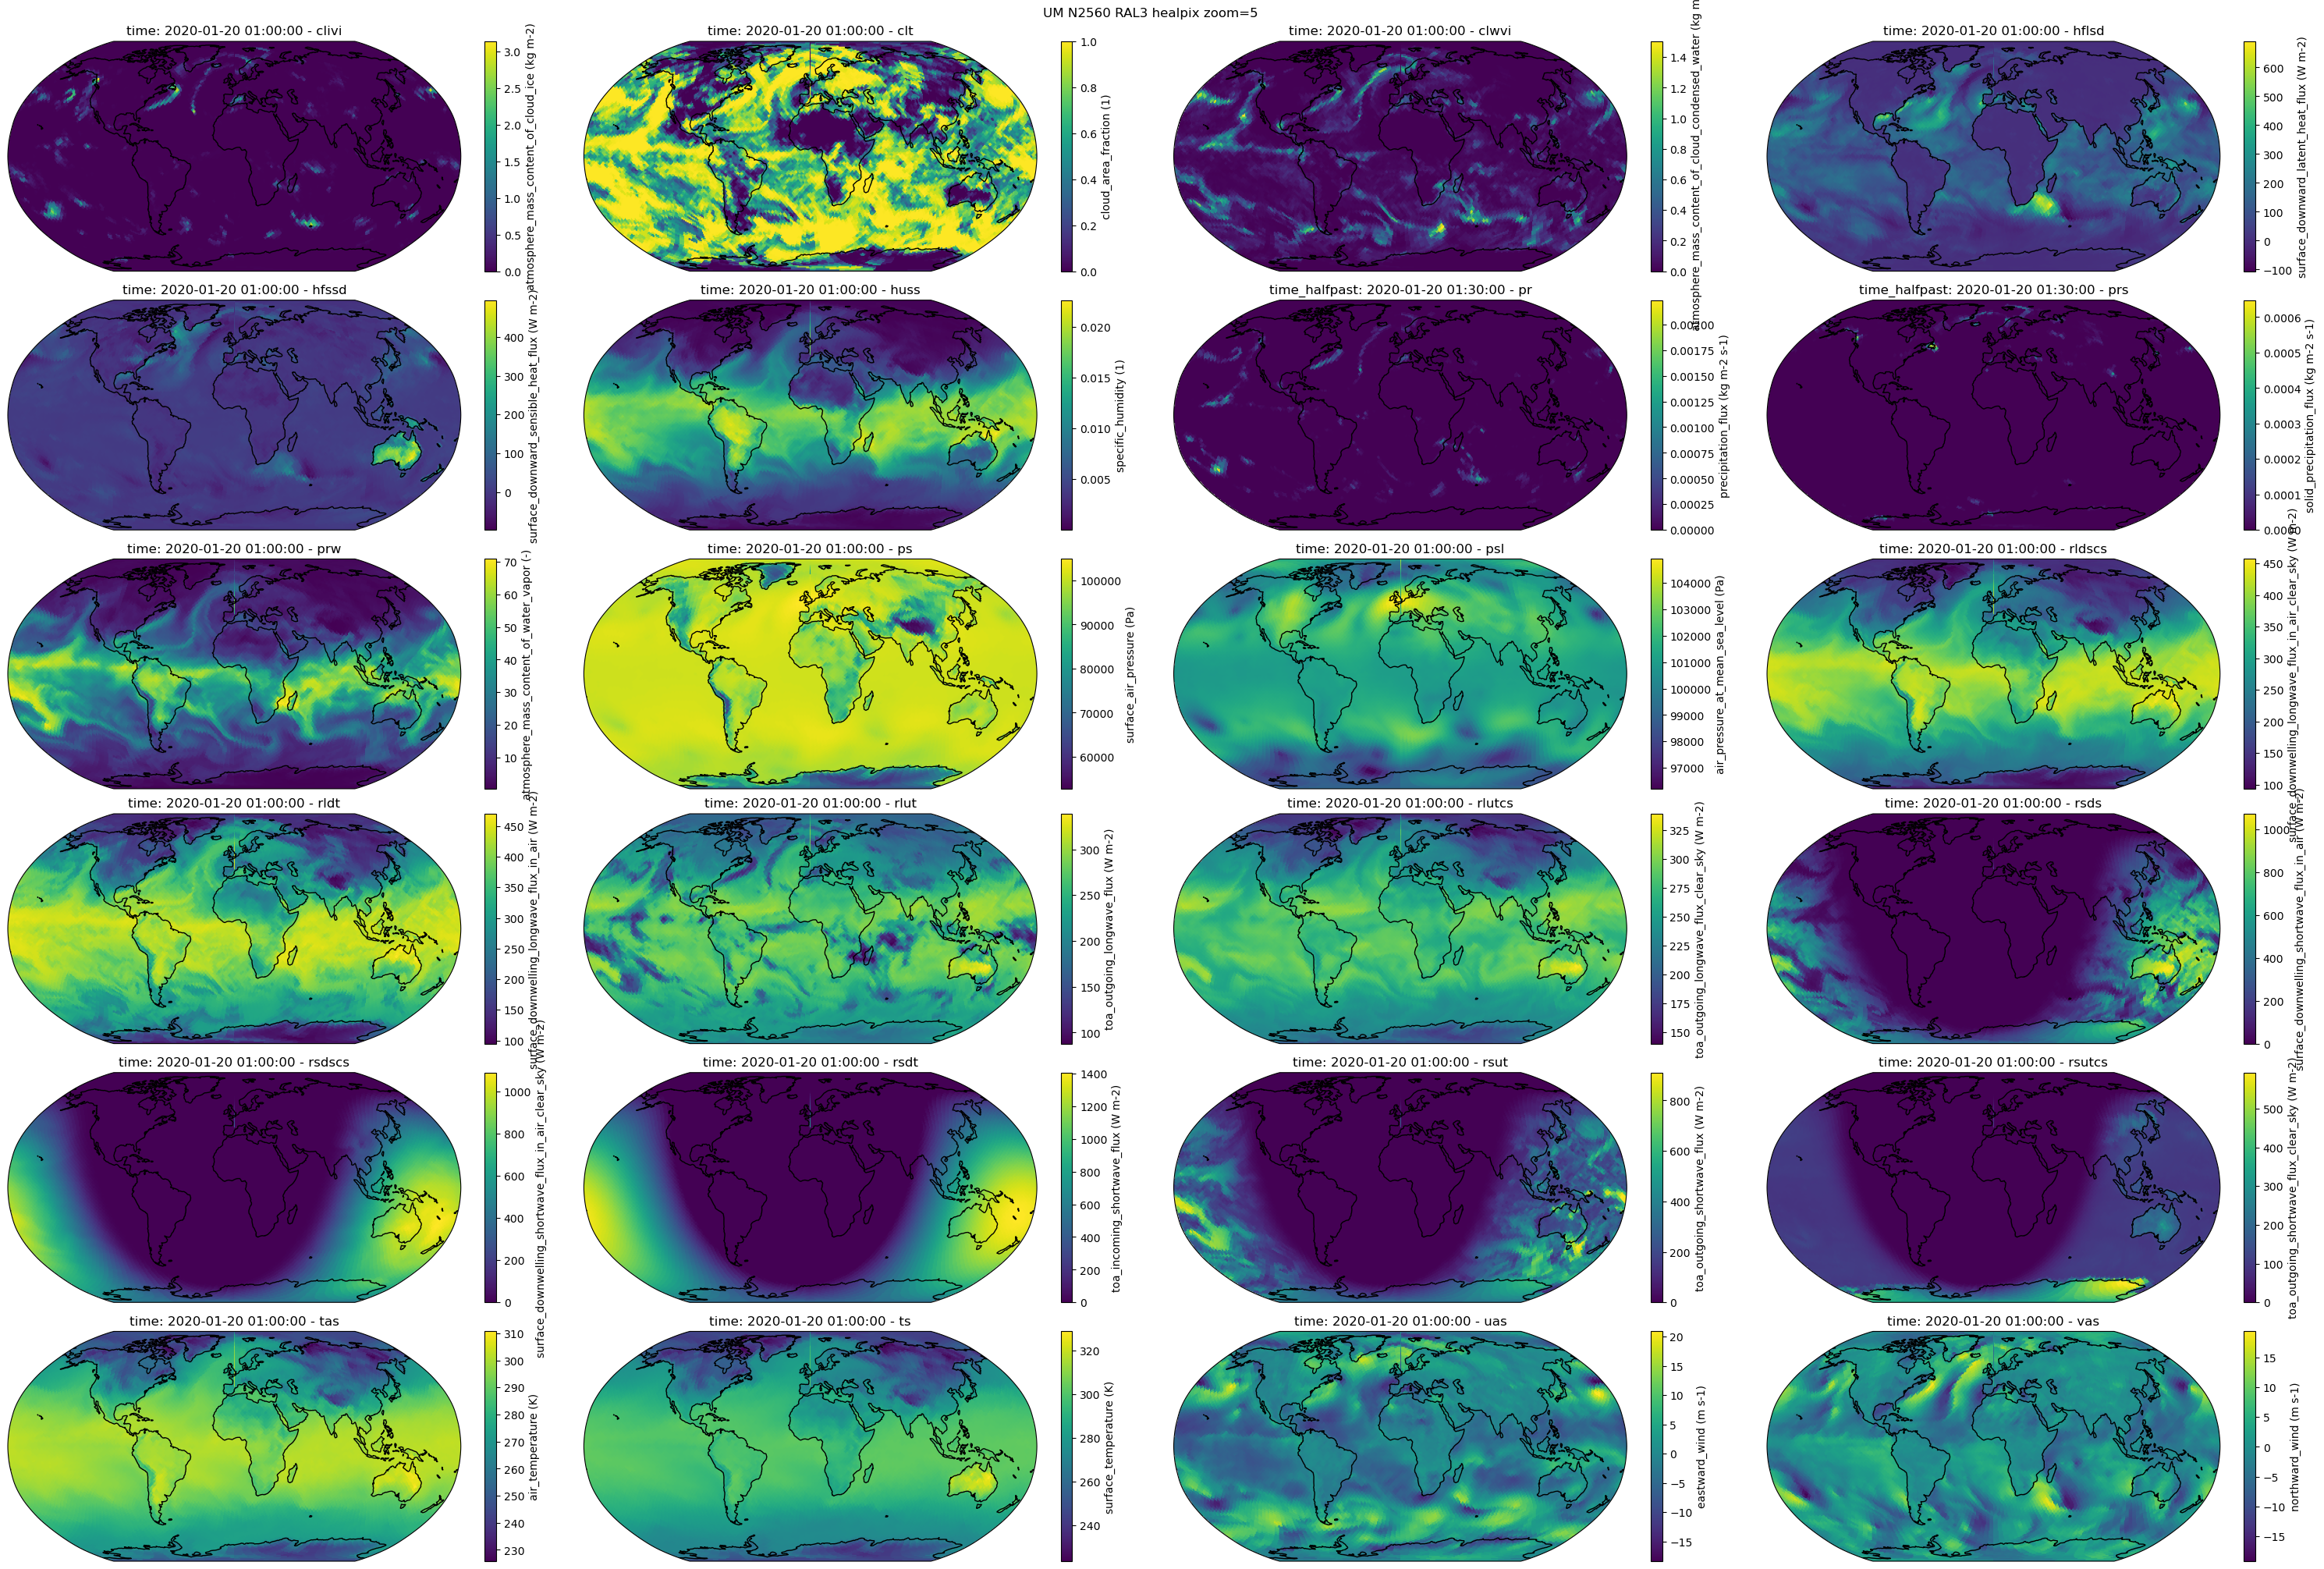

In [5]:
plot_all_fields_2d(5, 1)

In [6]:
ds3d = xr.open_zarr(url_tpls['3d'].format(zoom=6))
ds3d

<xarray.Dataset> Size: 378GB
Dimensions:   (cell: 49152, time: 3497, pressure: 25)
Coordinates:
  * cell      (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
  * pressure  (pressure) float32 100B 1.0 5.0 10.0 20.0 ... 950.0 975.0 1e+03
  * time      (time) datetime64[ns] 28kB 2020-01-20 ... 2021-04-01
Data variables:
    cli       (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    clw       (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    hur       (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    hus       (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    qg        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    qr        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    qs        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    ta        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    ua        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    va        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>
    zg        (time, pressure, cell) float64 34GB dask.array<chunksize=(1, 5, 49152), meta=np.ndarray>

In [7]:
def plot_all_fields_3d(zoom, time_idx, pressure):
    ds_plot = xr.open_zarr(url_tpls['3d'].format(zoom=zoom))

    projection = ccrs.Robinson(central_longitude=0)
    
    fig, axes = plt.subplots(3, 4, figsize=(30, 10), subplot_kw={'projection': projection}, layout='constrained')
    plt.suptitle(f'UM N2560 RAL3 healpix zoom={zoom} @ {pressure} hPa')
    
    for ax, (name, da) in zip(axes.flatten(), ds_plot.data_vars.items()):
        print(name)
        timename = [c for c in da.coords if c.startswith('time')][0]
        time = pd.Timestamp(ds_plot[timename].values[time_idx])
    
        data = da.isel(**{timename: time_idx}).sel(pressure=pressure) 
        ax.set_title(f'{timename}: {time} - {name}')
        ax.set_global()
        im = egh.healpix_show(data.values, ax=ax);
        long_name = da.long_name
            
        plt.colorbar(im, label=f'{long_name} ({da.attrs.get("units", "-")})')
        ax.coastlines()

cli
clw
hur
hus
qg
qr
qs
ta
ua
va
zg


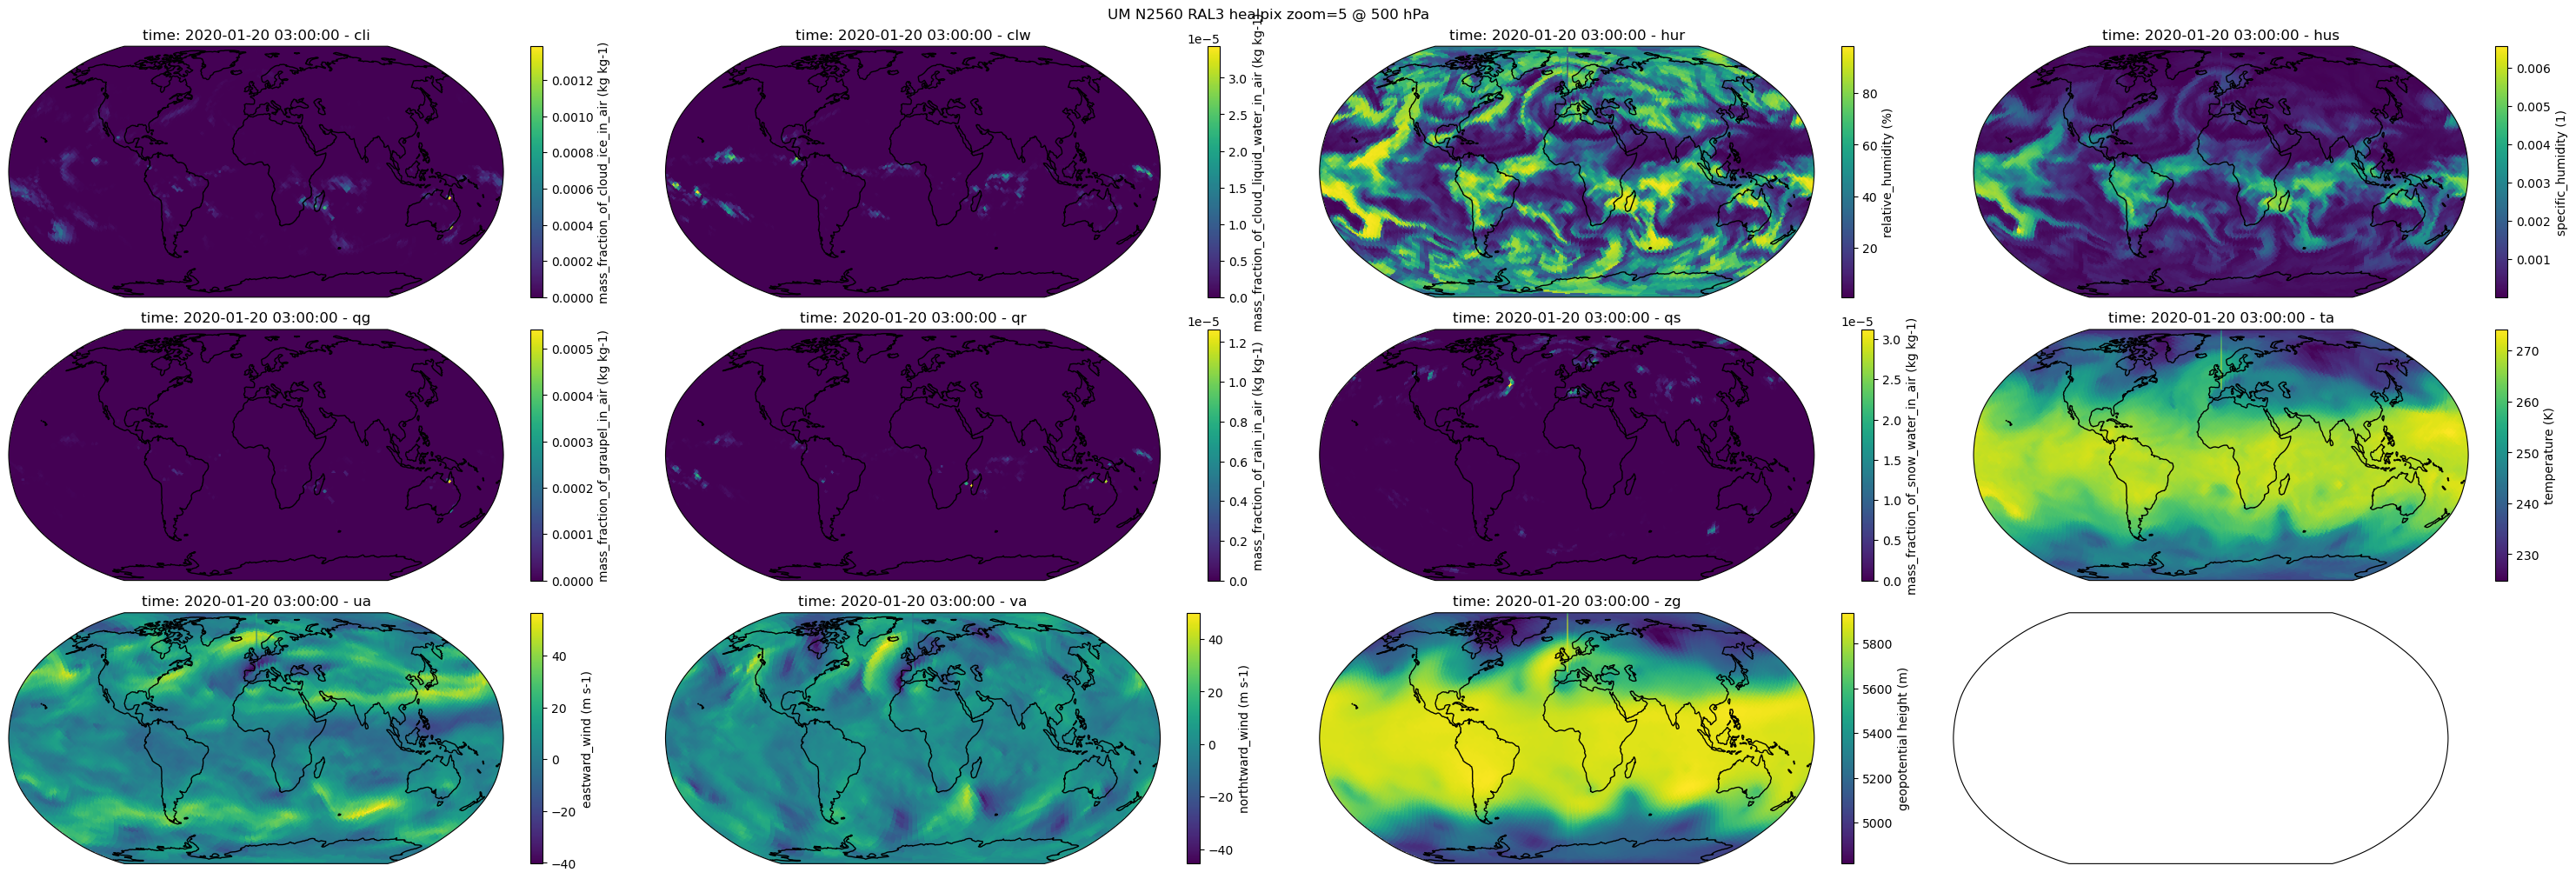

In [8]:
plot_all_fields_3d(5, 1, 500)